In [496]:
import pandas as pd
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sma
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, \
    pearsonr, spearmanr, kendalltau, f_oneway, kruskal, norm
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.stats as sms

Создаем исторические таблицы. 
Таблица dfp - данные с транзакциями. Столбцы: ИД клиента, сумма покупки, дата покупки.
Таблица dfc - клиентские данные. Столбцы: ИД клиента, возраст, пол, регион, годовой доход, флаг лояльности.

In [498]:
# Устанавливаем параметры генерации данных
np.random.seed(42)  # для воспроизводимости
num_clients = 100000

# Таблица 1: покупки клиентов за октябрь 2024
dates_october = pd.date_range(start="2024-10-01", end="2024-10-31")
client_ids = np.arange(1, num_clients + 1)
num_purchases = np.random.randint(0, 10, size=num_clients)  # число покупок для каждого клиента

# Генерация данных о покупках
purchase_data = []
for client_id, purchases in zip(client_ids, num_purchases):
    for _ in range(purchases):
        purchase_data.append({
            "client_id": client_id,
            "purchase_amount": round(np.random.uniform(5, 500), 2),  # сумма покупки в диапазоне 5-500
            "purchase_date": np.random.choice(dates_october)  # случайная дата октября
        })

dfp = pd.DataFrame(purchase_data)
print(dfp.head(5))

# Таблица 2: клиентские данные
dfc = pd.DataFrame({
    "client_id": client_ids,
    "age": np.random.randint(18, 70, size=num_clients),  # возраст клиента
    "gender": np.random.choice(["male", "female"], size=num_clients),  # пол клиента
    "region": np.random.choice(["North", "South", "East", "West"], size=num_clients),  # регион проживания
    "income": np.random.randint(20000, 150000, size=num_clients),  # годовой доход
    "loyalty_score": np.random.uniform(0, 1, size=num_clients)  # уровень лояльности (0-1)
})
print(dfc.head(5))

   client_id  purchase_amount purchase_date
0          1           196.40    2024-10-23
1          1           213.69    2024-10-04
2          1           328.97    2024-10-23
3          1            74.69    2024-10-31
4          1           328.36    2024-10-29
   client_id  age  gender region  income  loyalty_score
0          1   44    male   West   68313       0.820694
1          2   53  female  North   91958       0.295158
2          3   63    male  North   60929       0.471122
3          4   52    male  South   52136       0.975606
4          5   49    male   West  108991       0.572810


Создаем агрегированные таблицы с суммой покупок и кол-вом покупок по клиенту

In [500]:
# Группируем по client_id и считаем сумму покупок для каждого клиента
dfp_inc = dfp.groupby('client_id')['purchase_amount'].sum().reset_index()
# Переименовываем столбец для удобства
dfp_inc.rename(columns={'purchase_amount': 'total_purchase_amount'}, inplace=True)

# Группируем по client_id и считаем кол-во покупок для каждого клиента
dfp_cnt = dfp.groupby('client_id')['purchase_amount'].count().reset_index()
# Переименовываем столбец для удобства
dfp_cnt.rename(columns={'purchase_amount': 'total_purchase_count'}, inplace=True)

# Выводим первые 5 строк для проверки
print(dfp_inc.head())
print(dfp_cnt.head())

   client_id  total_purchase_amount
0          1                1261.40
1          2                 967.17
2          3                1770.06
3          4                1382.90
4          5                2482.11
   client_id  total_purchase_count
0          1                     6
1          2                     3
2          3                     7
3          4                     4
4          5                     6


Посмотрим на статистики исторических данных

In [502]:
print(dfp_inc.total_purchase_amount.agg(["count", "median", "mean", "std", "max"]))
print(dfp_cnt.total_purchase_count.agg(["count", "median", "mean", "std", "max"]))

count     90026.000000
median     1225.510000
mean       1268.114427
std         726.981685
max        3805.160000
Name: total_purchase_amount, dtype: float64
count     90026.000000
median        5.000000
mean          5.015840
std           2.581668
max           9.000000
Name: total_purchase_count, dtype: float64


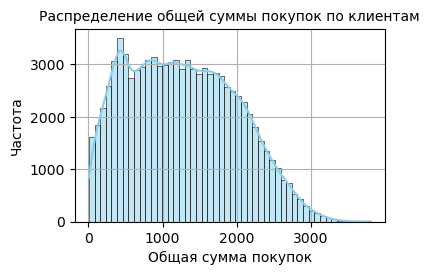

In [503]:
# Строим гистограмму распределения общей суммы покупок
plt.figure(figsize=(4, 2.5))
sns.histplot(dfp_inc['total_purchase_amount'], kde=True, bins=50, color='skyblue')

# Настройка графика
plt.title('Распределение общей суммы покупок по клиентам', fontsize=10)
plt.xlabel('Общая сумма покупок', fontsize=10)
plt.ylabel('Частота', fontsize=10)
plt.grid(True)

# Показываем график
plt.show()

In [504]:
test_stat_A, pvalue_A = shapiro(dfp_inc.total_purchase_amount)
print('Group A - Test Stat = %.23f, p-value = %.23f' % (test_stat_A, pvalue_A))

Group A - Test Stat = 0.97520356275802499990135, p-value = 0.00000000000000000000000


C:\Users\junte\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 90026.
  res = hypotest_fun_out(*samples, **kwds)


#### Задаем параметры теста

In [506]:
# Параметры
alpha = 0.05  # уровень значимостиal
beta = 0.2   # мощность теста
effect_size = 0.05  # МДЕ в процентах
mu_control = dfp_inc.total_purchase_amount.mean()  # средняя выручка
md_effect = mu_control * effect_size # МДЕ в абсолютных единицах
std = dfp_inc.total_purchase_amount.std()  # стандартное отклонение
mu_pilot = mu_control + md_effect  # средняя выручка с пользователя в экспериментальной группе
print('mean =',mu_control)
print('std =', std)
print('absolute effect =',md_effect)


mean = 1268.1144268322485
std = 726.9816848259933
absolute effect = 63.40572134161243


In [507]:
critical_value_left = mu_control + norm.ppf(alpha / 2) * (std/mu_control**0.5)  # Нижний критический порог
critical_value_right = mu_control + norm.ppf(1 - alpha / 2) * (std/mu_control**0.5)  # Верхний критический порог
print(critical_value_left, critical_value_right)

1228.1022353076632 1308.1266183568337


#### Расчет размера выборки с помощью готовых библиотек и cohen_d

In [509]:
# Расчет эффекта в терминах стандартного отклонения (Cohen's d)
cohen_d = md_effect / std 

# Расчет размера выборки для двухвыборочного t-теста
sample_size1 = sms.power.TTestIndPower().solve_power(effect_size=cohen_d, alpha=alpha, power=1-beta, alternative='two-sided')

# Вывод размера выборки

print(f"Необходимый размер выборки для каждой группы: {round(sample_size1)}")

Необходимый размер выборки для каждой группы: 2065


#### Расчет размера выборки по формуле

In [620]:
def estimate_sample_size(effect, std, alpha, beta):
    """Оценка необходимого размер групп."""
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    var = 2 * std ** 2
    sample_size = int((t_alpha + t_beta) ** 2 * var / (effect ** 2))
    return sample_size

#cohen_d = effect / std

sample_size2 = estimate_sample_size(md_effect, std, alpha, beta)

 

print(f'оценка необходимого размера групп = {sample_size2}')

оценка необходимого размера групп = 976


#### Расчет размера выборки и МДЕ бутстрапированием

In [513]:
#srednie
def bootstrap(test, control, iterations = 1000):
  iterations = iterations
  size = min(len(test), len(control))
  t_boots = [random.choices(test, weights=None, k=size) for _ in range(iterations)]
  c_boots = [random.choices(control, weights=None, k=size) for _ in range(iterations)]
  return t_boots, c_boots
# #ratio
# def bootstrap_ratio(test, control, iterations = 1000):
#   iterations = iterations
#   t_boots = [random.choices(test, weights=None, k=len(test)) for _ in range(iterations)]
#   c_boots = [random.choices(control, weights=None, k=len(control)) for _ in range(iterations)]
#   return t_boots, c_boots

### 1. Функции аггрегации
def agg_sum(array):
  return [sum(i) for i in array]

def agg_avg(array):
  return [sum(i)/len(i) for i in array]

def agg_median(array):
  return [np.median(i) for i in array]


### 2. Функции расчета статистики
def diff(test, control):
  return [test_i - control_i for (test_i,control_i) in zip(test,control)]

def compare(test, control):
  return [test_i/control_i for (test_i,control_i) in zip(test,control)]

def perc_compare(test, control):
  return [(test_i/control_i-1)*100 for (test_i,control_i) in zip(test,control)]
  
# Процент из генеральной совокупности
slices = [5,10,20,30,40,50]
minimum_lift = []
mde = []
n_items = []
users = []

dfp_inc['bucket_id'] = np.random.randint(1, 101, size=len(dfp_inc))  # Разбиение на 100 бакетов случайно

for i in tqdm(slices):
  test = dfp_inc[dfp_inc['bucket_id']<i]['total_purchase_amount'].to_list()
  control = dfp_inc[(dfp_inc['bucket_id']>=i) &\
                  (dfp_inc['bucket_id']<2*i)]['total_purchase_amount'].to_list()
  t_list, c_list = bootstrap(test, control)
  # Разница средних
  result = diff(agg_avg(t_list), agg_avg(c_list))
  minimum_lift.append((np.quantile(result, 0.975) - np.quantile(result, 0.025))/2)
  mde.append( minimum_lift[-1]/np.std(c_list))  
  n_items.append(i)
  users.append(min(len(test), len(control)))

#Вывод таблицы с mde 
pd.DataFrame({'minimum_lift': minimum_lift, 'mde': mde,
              'n_items': n_items, 'users': users})  
    

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:47<00:00,  7.93s/it]


,minimum_lift,mde,n_items,users
0,31.441675,0.042865,5,3607
1,21.656201,0.029320,10,8131
2,15.484906,0.021414,20,17206
3,12.960967,0.017815,30,26164
4,10.810884,0.014896,40,35102
5,9.615373,0.013235,50,43986


In [514]:
sample_size3 = users[0]
print(sample_size3)

3607


#### Проведем синтетические АА и АБ тесты для оценки вероятности ошибок 1 и 2 рода

In [516]:
def run_synthetic_experiments(values, sample_size, effect=0, n_iter= 10000):
    """Проводим синтетические эксперименты, возвращаем список p-value."""
    pvalues = []
    values = values.to_numpy()
    for _ in tqdm(range(n_iter)):
        a, b = np.random.choice(values, size=(2, int(sample_size),), replace=False)
        b += effect
        ##mannwhitneyu
        pvalue = ttest_ind(a, b).pvalue
        pvalues.append(pvalue)
    return np.array(pvalues)

def print_estimated_errors(pvalues_aa, pvalues_ab, alpha):
    """Оценивает вероятности ошибок."""
    estimated_first_type_error = np.mean(pvalues_aa < alpha)
    estimated_second_type_error = np.mean(pvalues_ab >= alpha)
    ci_first = estimate_ci_bernoulli(estimated_first_type_error, len(pvalues_aa))
    ci_second = estimate_ci_bernoulli(estimated_second_type_error, len(pvalues_ab))
    print(f'оценка вероятности ошибки I рода = {estimated_first_type_error:0.4f}')
    print(f'  доверительный интервал = [{ci_first[0]:0.4f}, {ci_first[1]:0.4f}]')
    print(f'оценка вероятности ошибки II рода = {estimated_second_type_error:0.4f}')
    print(f'  доверительный интервал = [{ci_second[0]:0.4f}, {ci_second[1]:0.4f}]')

def estimate_ci_bernoulli(p, n, alpha=0.05):
    """Доверительный интервал для Бернуллиевской случайной величины."""
    t = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    std_n = np.sqrt(p * (1 - p) / n)
    return p - t * std_n, p + t * std_n

pvalues_aa = run_synthetic_experiments(dfp_inc.total_purchase_amount, sample_size1, effect=0)
pvalues_ab = run_synthetic_experiments(dfp_inc.total_purchase_amount, sample_size1, effect=md_effect)
print_estimated_errors(pvalues_aa, pvalues_ab, alpha)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 302.60it/s]

оценка вероятности ошибки I рода = 0.0490
  доверительный интервал = [0.0448, 0.0532]
оценка вероятности ошибки II рода = 0.2036
  доверительный интервал = [0.1957, 0.2115]


##### Для выборки размера 2500 FPR = 0.05, FNR = 0.2 . Если используем выборку размером 3600 (посчитано бустрапом), то FNR = 0.1
Теперь попробуем добавить эффект и посчитать статзначимость

In [518]:
a = np.random.choice(dfp_inc.total_purchase_amount, size=int(sample_size1), replace=False)
b = np.random.choice(dfp_inc.total_purchase_amount, size=int(sample_size1), replace=False)
b = b + md_effect
print(a.mean(),b.mean())
print(ttest_ind(a, b).pvalue)
print(mannwhitneyu(a, b).pvalue)

1269.5469186046512 1301.2289529307598
0.16462030521624454
0.15587254612786405


#### ПОПРОБУЕМ УМЕНЬШИТЬ ДИСПЕРСИЮ CUPED

In [580]:
dfp_inc.head(10)

,client_id,total_purchase_amount,bucket_id
0,1,1261.40,90
1,2,967.17,53
2,3,1770.06,62
3,4,1382.90,99
4,5,2482.11,58
5,6,2584.91,21
6,7,83.76,21
7,8,1284.62,56
8,9,1724.50,39
9,10,925.19,5


In [588]:
df_new = dfp_inc.rename(columns={'total_purchase_amount': 'metric'})
df_new['metric'].values

array([1261.4 ,  967.17, 1770.06, ..., 1128.66, 1001.32,  916.17])

In [625]:

def add_covariate(df, corr, mean, sigma, sample_size, random_state=None):
    """
    Добавляет ковариату к случайной подвыборке из DataFrame с целевой метрикой.

    Параметры:
        df (pd.DataFrame): DataFrame с целевой метрикой (столбец 'metric').
        corr (float): Корреляция между целевой метрикой и ковариатой.
        mean (float): Среднее значение ковариаты (по умолчанию 2000).
        sigma (float): Стандартное отклонение ковариаты (по умолчанию 300).
        sample_size (int): Размер выборки (по умолчанию 1000).
        random_state (int, optional): Seed для воспроизводимости.

    Возвращает:
        pd.DataFrame: Новый DataFrame с добавленным столбцом 'covariate'.
    """
    # Берем случайную подвыборку
    df_sample = df.sample(n=int(sample_size), random_state=random_state)
    
    # Извлекаем целевую метрику
    metric = df_sample['metric'].values
    
    # Генерируем ковариату с заданной корреляцией
    covariate = corr * metric + np.sqrt(1 - corr**2) * np.random.normal(mean, sigma, len(metric))
    
    # Добавляем ковариату в DataFrame
    df_sample['covariate'] = covariate
    return df_sample

def generate_data(sample_size, corr, mean=2000, sigma=300):
    """Генерируем коррелированные данные исходной метрики и ковариаты.
    
    sample_size - размер выборки
    corr - корреляция исходной метрики с ковариатой
    mean - среднее значение исходной метрики
    sigma - стандартное отклонение исходной метрики

    return - pd.DataFrame со столбцами ['metric', 'covariate'],
        'metric' - значения исходной метрики,
        'covariate' - значения ковариаты.
    """
    means = np.array([mean, mean])
    cov = sigma ** 2 * np.array([[1, corr], [corr, 1]])
    data = np.random.multivariate_normal(means, cov, sample_size).astype(int)
    df = pd.DataFrame({'metric': data[:, 0], 'covariate': data[:, 1]})
    return df

def calculate_theta(metrics, covariates):
    """Вычисляем Theta.

    metrics - значения исходной метрики
    covariates - значения ковариаты

    return - theta.
    """
    covariance = np.cov(covariates, metrics)[0, 1]
    variance = covariates.var()
    theta = covariance / variance
    return theta

def check_ttest(df_control, df_pilot):
    """Проверяет гипотезу о равенстве средних с помощью t-test.

    return - pvalue.
    """
    values_control = df_control['metric'].values
    values_pilot = df_pilot['metric'].values
    _, pvalue = ttest_ind(values_control, values_pilot)
    return pvalue

def check_cuped(df_control, df_pilot, df_theta):
    """Проверяет гипотезу о равенстве средних с использованием CUPED.
    
    df_control и df_pilot - данные контрольной и экспериментальной групп
    df_theta - данные для оценки theta

    return - pvalue.
    """
    theta = calculate_theta(df_theta['metric'], df_theta['covariate'])
    metric_cuped_control = df_control['metric'] - theta * df_control['covariate']
    metric_cuped_pilot = df_pilot['metric'] - theta * df_pilot['covariate']
    df_control['metric_cuped'] = df_control['metric'] - theta * df_control['covariate']
    df_pilot['metric_cuped'] = df_pilot['metric'] - theta * df_pilot['covariate']
    _, pvalue = ttest_ind(metric_cuped_control, metric_cuped_pilot)
    return pvalue


#sample_size = 1000      # размер групп
corr = 0.7             # корреляция ковариаты с целевой метрикой
#effect = 20             # размер эффекта

df_control = add_covariate(df_new, corr, mu_control, std,sample_size1)
df_pilot = add_covariate(df_new, corr, mu_control, std,sample_size1)
df_pilot['metric'] += md_effect


df_theta = pd.concat([df_control, df_pilot])

pvalue_cuped = check_cuped(df_control, df_pilot, df_theta)

print(pvalue_cuped)
print('Std в контроле =',df_control.metric.std())
print('Std в контроле КУПЕД =',df_control.metric_cuped.std())
print('Std в тесте =',df_pilot.metric.std())
print('Std в тесте КУПЕД =',df_pilot.metric_cuped.std())

5.640430757982495e-08
Std в контроле = 742.9120625142306
Std в контроле КУПЕД = 517.4310966489759
Std в тесте = 730.4157403605615
Std в тесте КУПЕД = 529.9395219207858


In [521]:
estimated_first_type_error_ttest = np.mean(np.array(pt) < alpha)
estimated_first_type_error_cuped = np.mean(np.array(pc) < alpha)
print(estimated_first_type_error_ttest, estimated_first_type_error_cuped)

0.329 0.544


#### КЛАСТЕРИЗАЦИЯ 

[[ 0.03946591 -0.44538894  1.11768216]
 [ 0.63994127  0.18401012 -0.7047995 ]
 [ 1.30713611 -0.64194139 -0.09458185]
 ...
 [-0.02725357  1.61556358 -1.36099188]
 [-0.96132636  1.00410552  0.6471559 ]
 [ 0.30634385 -1.53390727 -0.22580575]]


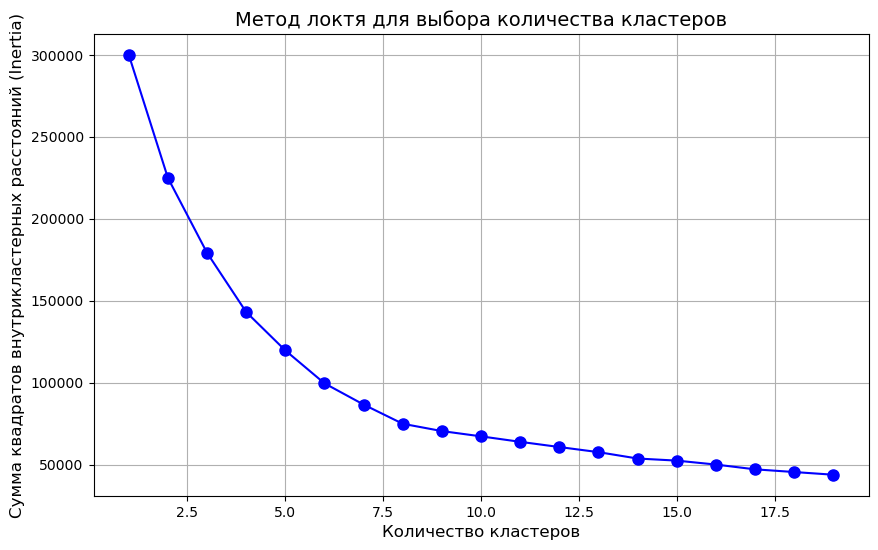

In [523]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import random

# Загружаем данные о клиентах

# Подготовка данных для кластеризации
numeric_columns = ["age", "income", "loyalty_score"]  # числовые столбцы для кластеризации
data_for_clustering = dfc[numeric_columns]
#print(data_for_clustering.head(10))

# Нормализация данных
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)
print(scaled_data)
# Метод локтя для определения количества кластеров
inertia = []  # Список для хранения суммы квадратов внутрикластерных расстояний
k_range = range(1, 20)  # Диапазон возможных кластеров

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Построение графика метода локтя
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-', markersize=8)
plt.xlabel('Количество кластеров', fontsize=12)
plt.ylabel('Сумма квадратов внутрикластерных расстояний (Inertia)', fontsize=12)
plt.title('Метод локтя для выбора количества кластеров', fontsize=14)
plt.grid(True)
plt.show()


In [525]:
# Кластеризация (выбираем 10 кластеров как пример)
kmeans = KMeans(n_clusters=10, random_state=42)
dfc['cluster'] = kmeans.fit_predict(scaled_data)
#print(dfc.head(10))
# Разделение клиентов на группы A и B
group_A = []
group_B = []

# Равномерное распределение клиентов из каждого кластера
for cluster_id in dfc['cluster'].unique():
    cluster_clients = dfc[dfc['cluster'] == cluster_id]
    #if cluster_id == 1:
        #print(cluster_clients.head(10))
    sampled_clients = cluster_clients.sample(n= 2 * int(sample_size) // 10)#, random_state=42)  # Пропорционально числу кластеров
    half = len(sampled_clients) // 2
    
    group_A.extend(sampled_clients.iloc[:half]['client_id'].tolist())
    group_B.extend(sampled_clients.iloc[half:]['client_id'].tolist())

# Проверка итоговых размеров групп
print('Sizes',len(group_A), len(group_B))
#print(group_A[:10],group_B[:10])

group_A_df = dfc[dfc['client_id'].isin(group_A)]
group_B_df = dfc[dfc['client_id'].isin(group_B)]

group_A_df = group_A_df.merge(dfp_inc, on='client_id', how='left')
group_B_df = group_B_df.merge(dfp_inc, on='client_id', how='left')

# Просмотр первых 5 строк для каждой группы
print(group_A_df.total_purchase_amount.mean(),'\n', group_B_df.total_purchase_amount.mean())

Sizes 1000 1000
1248.169051339286 
 1307.4422869955158


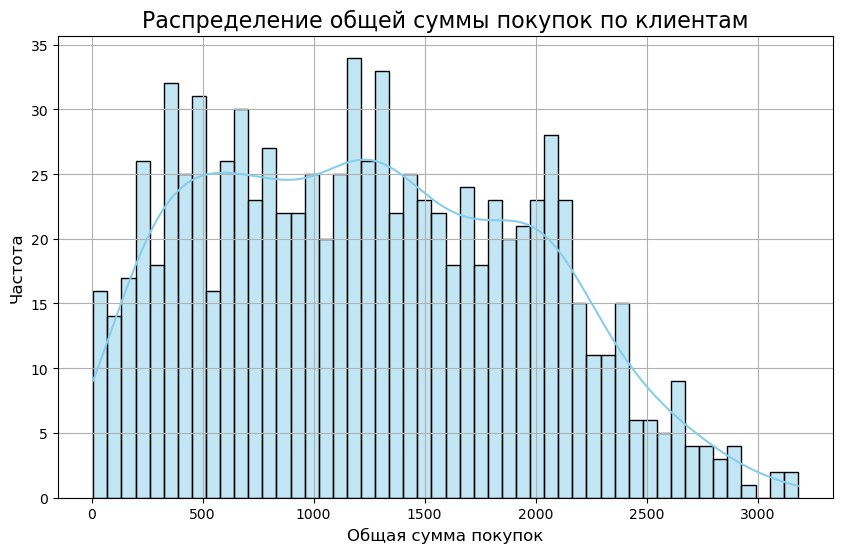

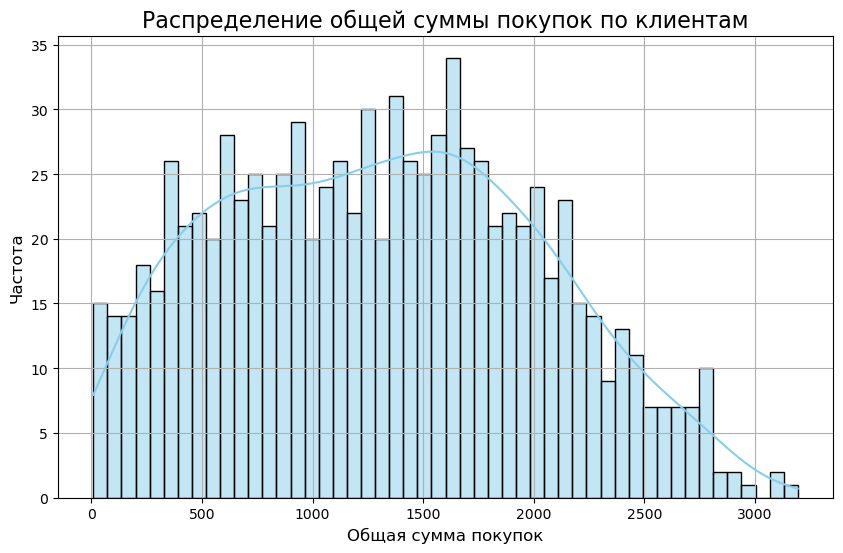

In [526]:
# Строим гистограмму распределения общей суммы покупок группы А
plt.figure(figsize=(10, 6))
sns.histplot(group_A_df.total_purchase_amount, kde=True, bins=50, color='skyblue')

# Настройка графика
plt.title('Распределение общей суммы покупок по клиентам', fontsize=16)
plt.xlabel('Общая сумма покупок', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(True)

# Показываем график
plt.show()

# Строим гистограмму распределения общей суммы покупок группы Б
plt.figure(figsize=(10, 6))
sns.histplot(group_B_df.total_purchase_amount, kde=True, bins=50, color='skyblue')

# Настройка графика
plt.title('Распределение общей суммы покупок по клиентам', fontsize=16)
plt.xlabel('Общая сумма покупок', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(True)

# Показываем график
plt.show()

In [527]:
# Параметры
dates_range = pd.date_range(start="2024-11-01", end="2024-11-14")  # Для двух недель
num_clients_A = len(group_A)  # Количество клиентов в группе A
num_clients_B = len(group_B)  # Количество клиентов в группе B

print(num_clients_A,num_clients_B)
# Генерация покупок для группы A
purchase_data_A = []
for client_id in group_A:
    num_purchases = np.random.randint(1, 10)  # случайное количество покупок (от 1 до 10)
    for _ in range(num_purchases):
        purchase_data_A.append({
            "client_id": client_id,
            "purchase_amount": round(np.random.uniform(5, 500), 2),  # случайная сумма покупки
            "purchase_date": np.random.choice(dates_range)  # случайная дата
        })

# Генерация покупок для группы B (с увеличением суммы покупок на 6%)
purchase_data_B = []
for client_id in group_B:
    num_purchases = np.random.randint(1, 10)  # случайное количество покупок (от 1 до 10)
    for _ in range(num_purchases):
        purchase_data_B.append({
            "client_id": client_id,
            "purchase_amount": round(np.random.uniform(5, 500) * 1.01, 2),  # увеличение суммы на 5%
            "purchase_date": np.random.choice(dates_range)  # случайная дата
        })

# Создаем DataFrame для покупок группы A и B

df_A = pd.DataFrame(purchase_data_A)
df_B = pd.DataFrame(purchase_data_B)

dfp_inc_A = df_A.groupby('client_id')['purchase_amount'].sum().reset_index()
dfp_inc_A.rename(columns={'purchase_amount': 'total_purchase_amount'}, inplace=True)
dfp_inc_B = df_B.groupby('client_id')['purchase_amount'].sum().reset_index()
dfp_inc_B.rename(columns={'purchase_amount': 'total_purchase_amount'}, inplace=True)

# Проверим, как выглядят данные
print(dfp_inc_A.head(10))
print(dfp_inc_B.head(10))
print(dfp_inc_A.total_purchase_amount.mean())
print(dfp_inc_B.total_purchase_amount.mean())
print(dfp_inc_A.total_purchase_amount.std())
print(dfp_inc_B.total_purchase_amount.std())


1000 1000
   client_id  total_purchase_amount
0         66                1666.76
1        355                2369.17
2        515                1413.40
3        530                 777.72
4        604                 486.54
5        872                1344.36
6        924                1815.98
7       1095                 179.01
8       1096                1152.55
9       1308                 868.63
   client_id  total_purchase_amount
0          9                1575.19
1        150                2190.53
2        271                1792.94
3        354                1295.54
4        632                 771.53
5        726                 651.57
6        779                1689.88
7        795                1088.83
8       1052                1043.65
9       1204                1619.32
1273.0726900000002
1255.2530900000002
719.1359375426379
704.3002829479146


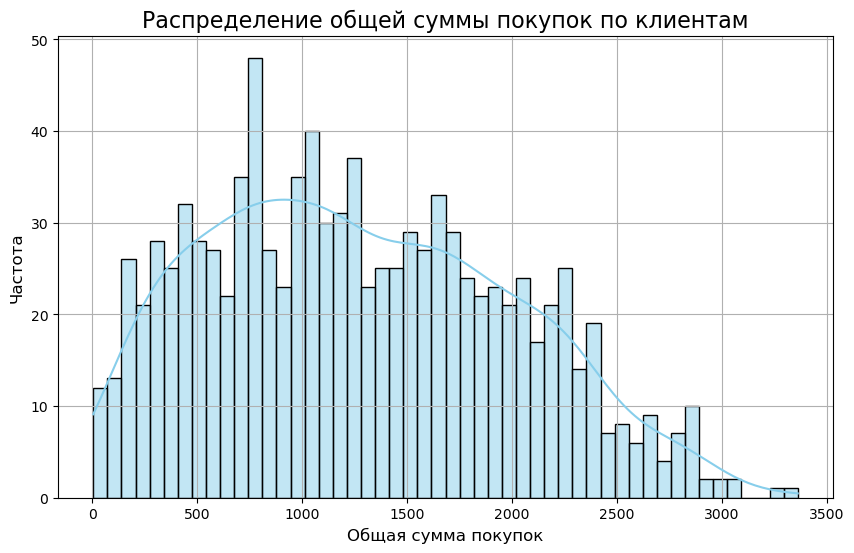

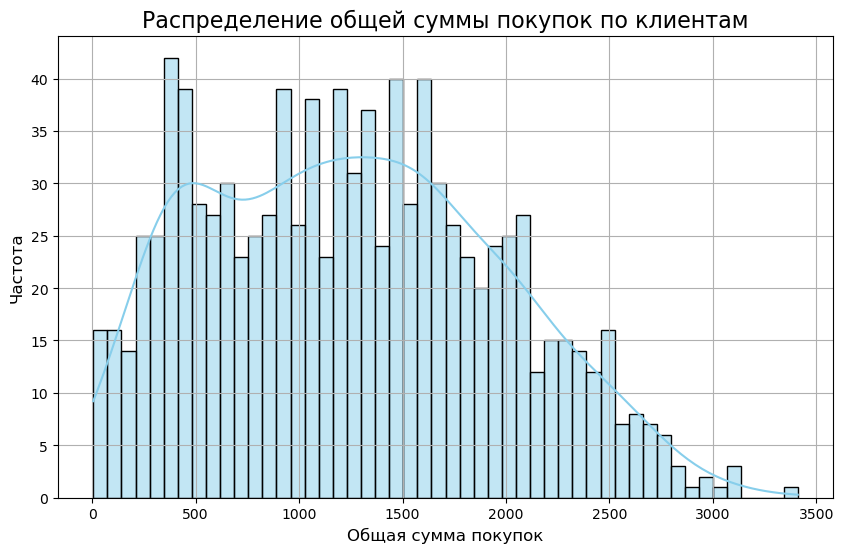

In [528]:
# Строим гистограмму распределения общей суммы покупок группы А
plt.figure(figsize=(10, 6))
sns.histplot(dfp_inc_A.total_purchase_amount, kde=True, bins=50, color='skyblue')

# Настройка графика
plt.title('Распределение общей суммы покупок по клиентам', fontsize=16)
plt.xlabel('Общая сумма покупок', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(True)

# Показываем график
plt.show()

# Строим гистограмму распределения общей суммы покупок группы Б
plt.figure(figsize=(10, 6))
sns.histplot(dfp_inc_B.total_purchase_amount, kde=True, bins=50, color='skyblue')

# Настройка графика
plt.title('Распределение общей суммы покупок по клиентам', fontsize=16)
plt.xlabel('Общая сумма покупок', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(True)

# Показываем график
plt.show()

Проводим тест Шапиро для проверки на нормальность распределений

In [530]:
test_stat_A, pvalue_A = shapiro(dfp_inc_A.total_purchase_amount)
print('Group A - Test Stat = %.23f, p-value = %.23f' % (test_stat_A, pvalue_A))

# Тест Шапиро для группы B
test_stat_B, pvalue_B = shapiro(dfp_inc_B.total_purchase_amount)
print('Group B - Test Stat = %.23f, p-value = %.23f' % (test_stat_B, pvalue_B))

Group A - Test Stat = 0.97550604927294171098140, p-value = 0.00000000000604395758781
Group B - Test Stat = 0.97750340183821837758416, p-value = 0.00000000002541100545733


Тест Левена для проверки гомогенности дисперсий

In [532]:
test_stat, pvalue = levene(dfp_inc_A.total_purchase_amount, dfp_inc_B.total_purchase_amount)
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 0.6489, p-value = 0.4206


In [533]:
test_stat, pvalue = mannwhitneyu(dfp_inc_A.total_purchase_amount,dfp_inc_B.total_purchase_amount)
print('Test Stat %.4f, p-value %.4f' % (test_stat, pvalue))

Test Stat 505283.5000, p-value 0.6825


In [534]:
# def AB_Test():
    
#     # Packages
#     from scipy.stats import shapiro
#     import scipy.stats as stats
    
#     # Split A/B
#     groupA = dfp_inc_A['total_purchase_amount']
#     groupB = dfp_inc_A['total_purchase_amount']
    
#     # Assumption: Normality
#     ntA = shapiro(groupA)[1] < 0.05
#     ntB = shapiro(groupB)[1] < 0.05
#     # H0: Distribution is Normal! - False
#     # H1: Distribution is not Normal! - True
    
#     if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
#         # Parametric Test
#         # Assumption: Homogeneity of variances
#         leveneTest = stats.levene(groupA, groupB)[1] < 0.05
#         # H0: Homogeneity: False
#         # H1: Heterogeneous: True
        
#         if leveneTest == False:
#             # Homogeneity
#             ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
#             # H0: M1 == M2 - False
#             # H1: M1 != M2 - True
#         else:
#             # Heterogeneous
#             ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
#             # H0: M1 == M2 - False
#             # H1: M1 != M2 - True
#     else:
#         # Non-Parametric Test
#         ttest = stats.mannwhitneyu(groupA, groupB)[1] 
#         # H0: M1 == M2 - False
#         # H1: M1 != M2 - True
        
#     # Result
#     temp = pd.DataFrame({
#         "AB Hypothesis":[ttest < 0.05], 
#         "p-value":[ttest]
#     })
#     temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
#     temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
#     temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
#     # Columns
#     if (ntA == False) & (ntB == False):
#         temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
#         temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
#     else:
#         temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
#     # Print Hypothesis
#     print("# A/B Testing Hypothesis")
#     print("H0: A == B")
#     print("H1: A != B", "\n")
    
#     return temp
    
    
    
# # Apply A/B Testing
# AB_Test()

In [535]:
# dfp_inc_A['total_purchase_amount'].std()

In [536]:
# dfp_inc_B['total_purchase_amount'].mean()

In [537]:
# quantile_95 = norm.ppf(0.95, loc=50, scale=30)
# print(f"95%-квантиль: {quantile_95}")